In [15]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#CASO DE N ROBOTS EN UN ESPACIO n-DIMENSIONAL

#todos los agentes siguen las mismas ecuaciones de trayectoria

np.random.seed(123)

#Definimos en una función las ecuaciones de la trayectoria 

def fun(w):
    f1 = 15*np.sin(2*w)
    f2 = 30*np.sin(w)*(np.sqrt(0.5*(1-0.5*(np.sin(w))**2)))
    f3 = 3+5*np.cos(2*w)
    return np.array([f1, f2, f3])

#funciones phi
def phi(vec_pos):
    f = fun(vec_pos[-1])
    return vec_pos[:-1] - f

# calculamos la derivada de las ecuaciones de la trayectoria
def d_fun(w):
    #derivada central
    h = 1e-8 #paso
    df = (fun(w+h)-fun(w-h))/(2*h)
    return df

#matriz lapaciana de un grafo (los agentes están comunicados con los vecinos adyacentes)
def grafo_L(N):
    #N: nº de agentes 
    L = np.zeros([N,N])  
    
    # Llenar la diagonal con 2 
    np.fill_diagonal(L, 2)
    
    # Llenar las diagonales justo arriba y abajo de la diagonal principal con -1
    np.fill_diagonal(L[:, 1:], -1)
    np.fill_diagonal(L[1:, :], -1)
    
    # Llenar las esquinas con -1
    L[0, -1] = -1
    L[-1, 0] = -1
    
    return L

def vector_field(xi,t,k,n,N,ww,kc,L):
    #xi: posiciones de todos los agentes (vector columna con las 4 coordenadas )
    #t: tiempo
    #k: ganancias positivas
    #n: dimensiones 
    #N: nº de agentes 
    #L: matriz laplaciana de un grafo

    lista = np.arange(0,(n+1)*N+1,(n+1))
    k = k*N

    PHI = np.zeros(n*N) #lista vacía de funciones surface
    df = np.zeros(n*N)  #lista vacía de las derivadas 
    w = np.zeros(N)     #lista vacía para las coordenadas virtuales
    j = 0 
    for i in lista[:-1]: 
        x = xi[i:i+(n+1)]               #coordenada inicial + virtual de cada agente
        PHI[i-j:(i-j)+n] = phi(x)       #función surface 
        df[i-j:(i-j)+n] = d_fun(x[-1])  #derivada 
        w[j] = x[-1]                    #coordenadas virtuales 
        j += 1

    xi_eta = (-1)**n*df-k*PHI

    #sumatorio

    l = k*PHI*df
    # Convertir la matriz l en una matriz de n filas
    matriz_l = l.reshape((N, -1))
    #sumar a los largo del eje de las filas 
    suma = np.sum(matriz_l, axis=1)

    #función de coordinación 
    c = -L@np.transpose(w-ww)
    
    xi4 = (-1)**n+suma+kc*c

    #path-following guiding vector field 
    xi_eta = np.concatenate((xi_eta.reshape((N,n)),np.array([xi4]).T),axis=1)
    xi_eta = xi_eta.reshape((N*(n+1),-1)).T

    return xi_eta[0]

#------------------------------------------------------------------------

#Parámetro de simulación 
n = 3           #dimensiones del espacio
N = 5          #nº de agentes 
t = np.linspace(0,200,1000) #tiempo de integración 
ki =[1,1,2] #ganancias 

#coordenadas iniciales de los robots 
#pos = np.random.rand(N, n)*100 #filas: dimensiones
                           #columnas: nº de robots
pos = np.random.randint(-50, 51, size=(N, n))


#añadimos a la matriz de posiciones la coordenada virtual w 
w = np.ones((N,1)) #ejemplo: todos valen 1 

#concatenamos las dos matrices a lo largo de las filas 
Xi = np.concatenate((pos, w), axis=1)
Xi = Xi.reshape((N*(n+1),-1)).T #apilamos en un vector

#matriz lapaciana de un grafo 
L = grafo_L(N)

#parámetros para la componente de coordinación 
T = 2*np.pi #periodo 
Delta =  T/(2*N)
kc = 300

ww = np.zeros(N)
for i in range(N):
    ww[i] = i*Delta

#resolvemos las ecuación diferencial 
sol = odeint(vector_field,Xi[0],t,args=(ki,n,N,ww,kc,L))


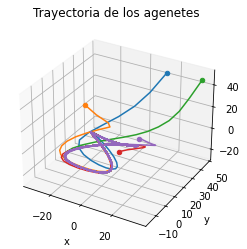

In [16]:
#representación gráfica 

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

lista = np.arange(0,(n+1)*N+1,(n+1))
for i in lista[:-1]: 
    ax.plot(sol[:,i], sol[:,i+1], sol[:,i+2])
    ax.scatter(sol[0,i],sol[0,i+1], sol[0,i+2], marker='o')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Trayectoria de los agenetes')
plt.show()